# Front equation

Dadas las ecuaciones del modelo SIR-$\alpha$ espacial,

\begin{cases}
    \partial_t S &= -\beta SI^{\alpha}, \\
    \partial_t I &= \beta SI^{\alpha} - \gamma I + D \nabla^2 I,
\end{cases}

nos proponemos encontrar una ecuación para el el campo de desplazamiento del frente $u(y,t)$ dado por,

$$\max _x[I(x, y, t)]=I(u(y, t), y, t).$$

Para referencia, también está la alternativa de definir el campo de desplazamiento de la siguiente manera,

$$ u(y,t) =  \frac{\sum_{i = 0}^{L_x} i \; I(i,y,t)}{\sum_{j=0}^{L_x} I(j,y,t)}.$$


## Ansatz

Proponemos una solución del tipo, 

\begin{cases}
    I(x,y,t) &= f(x - u(y,t)), \\
    S(x,y,t) &= g(x - u(y,t)),
\end{cases}

y reemplazamos en las ecuaciones del modelo. Veamos que pasa. 

Para las derivadas temporales tenemos, 

$$\partial_t S = -g' \partial_t u,$$ 
$$\partial_t I = -f' \partial_t u.$$

Derivadas espaciales en $x$,

$$\partial_x I = f',$$
$$\partial_{xx} I = f''.$$

Derivadas espaciales en $y$,

$$\partial_y I = -f'\partial_y u,$$
$$\partial_{yy} I = f'' (\partial_y u)^2 - f' \partial_{yy} u$$

Reemplazando obtenemos

\begin{cases}
    g' \partial_t u &= \beta g f^{\alpha}, \\
    f' \partial_t u &= -\beta g f^{\alpha} + \gamma f - Df'' -Df''(\partial_y u)^2 + Df'\partial_{yy} u, \\
\end{cases}

## Caso homgéneo

En el caso homogéneo tenemos $\beta$ constante. Observemos qué sucede con el sistema de ecuaciones anterior si usamos $u(y,t) = ct$.

\begin{cases}
    cg' &= \beta g f^{\alpha}, \\
    cf' &= -\beta g f^{\alpha} + \gamma f - Df'', \\
\end{cases}

## Juego de ecuaciones

Las sumo y obtengo,

$$(f' + g') \partial_t u = \gamma f - Df'' -Df''(\partial_y u)^2 + Df'\partial_{yy} u,$$

No me convence, vamos a tratar con la segunda ecuación multiplicando por $f'$,

$${f'}^2 \partial_t u = (-\beta g f^\alpha + \gamma f - Df'')f' - Df''f'(\partial_y u)^2 + D {f'}^2\partial_{yy}u,$$

lo que queremos hacer ahora es integrar sobre $x$, nos interasa particularmente lo que sucede con los coeficientes de $(\partial_y u)^2$ y $\partial_{yy} u$. Esto es $f''f'$ y ${f'}^2$ respectivamente. Es claro que al integrar ${f'}^2$ resulta algo mayor a cero, de modo que el término $\partial_{yy} u$ siempre sobrevive, independientemente de $f$. 

Por otro lado $f''f'$ no es tan trivial, podemos ver que si $f$ es "par" respecto de $u$ entonces  la integral de $f''f'$ se anula, de modo que el término $(\partial_y u)^2$ también se anula. De las simulaciones sabemos que este no es el caso, sin embargo con $\alpha = 1$ numéricamente pareciera que este término se anula igualmente.

Numéricamente se observa que las integrales de $f''f'$ y $f f'$ se anulan (al menos para $\alpha = 3$ que es lo que he visto). De modo que llamando $K = \int f'^2 \; dx$ la ecuación resultante se reduce a la siguiente.

$$ \partial_t u = D\partial_{yy}u -\frac{1}{K} \int \beta g f^\alpha f' \;dx

Ahora si integro en $x$ expresando a $\beta(x,y)=\beta(y)\langle \beta \rangle_x$ y escribo $\int\langle \beta \rangle_x g f^{\alpha}f' = \Alpha$, se tiene finalmente

$$ \partial_t u = D\partial_{yy}u -\frac{\Alpha}{K}\beta(y).$$

Donde $\beta(y)$ es un ruido.




Nata: Con $\alpha = 3$ numéricamente $\frac{A}{K}$ me da aproximadamente $-0.5$ para todo t.

Simulo rápidamente la ecuación obtenida.

In [4]:
import cupy as cp

Ly = 2048
beta0 = 20.
D = 1
A_K = -.5
p=.5

#random beta
beta = cp.random.choice([0,beta0],size=Ly,p = [p,1-p])

#initial condition
u = cp.zeros(Ly)


#time step
dt = 0.01

#number of time steps
it_max = 100000

#dyy kernel

dyy = cp.ElementwiseKernel(
    'raw float64 u, uint64 Ly',
    'float64 dyy',
    '''
    int id = i % Ly;
    int im1 = (id-1+Ly) % Ly;
    int ip1 = (id+1) % Ly;
    dyy = u[ip1] - 2*u[i] + u[im1];
    ''',
    'dyy')

#mesures
u_cm = cp.zeros(it_max)
width = cp.zeros(it_max)



#solve
dyyu = cp.zeros(Ly)
for it in range(it_max):
    u_cm[it] = u.mean()
    width[it] = u.std()
    dyy(u,Ly,dyyu)
    u = u + dt*(D*dyyu - A_K*beta) 



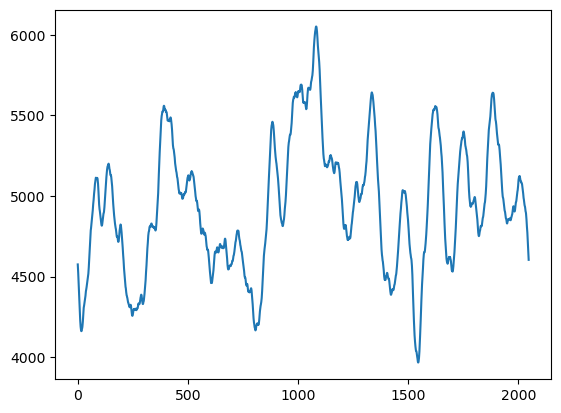

In [5]:
#plot u 

import matplotlib.pyplot as plt
plt.plot(u.get())
plt.show()

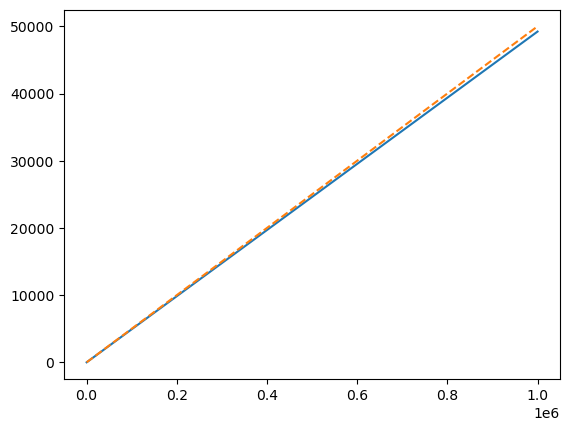

In [62]:
#plot u_cm

plt.plot(u_cm.get())
plt.plot(.05*np.arange(it_max),'--')

plt.show()

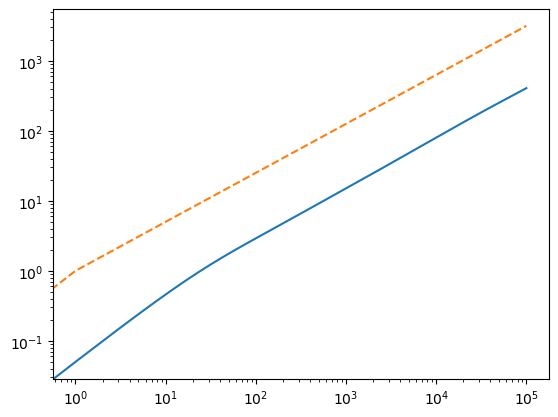

In [6]:
#plot width
import numpy as np

plt.plot(width.get())
#power law
plt.plot(np.arange(it_max)**.7,'--')

plt.xscale('log')
plt.yscale('log')
plt.show()